In [53]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.dates import num2date
from matplotlib.dates import date2num
import matplotlib.mlab as mlab
import datetime
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, grid_search
from sklearn.metrics import roc_curve,auc
from scipy import interp
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

In [ ]:
import sys
try:
    import pyfolio as pf
except:
    !{sys.executable} -m pip install pyfolio
    import pyfolio as pf

In [ ]:
# finance module is no longer part of matplotlib
try:
    from mpl_finance import candlestick_ohlc as candlestick
    from mpl_finance import volume_overlay3
except:
    !{sys.executable} -m pip install https://github.com/matplotlib/mpl_finance/archive/master.zip
    from mpl_finance import candlestick_ohlc as candlestick
    from mpl_finance import volume_overlay3

### The following Python libraries are used
>*   numpy 1.14.3
*   pandas 0.23.0
*   matplotlib 2.2.2
*   seaborn 0.8.1
*   scipy 1.1.0
*   statsmodels 0.9.0
*   mpl_finance
*   sklearn

### *** About the Data (bitstampUSD) ***
> 1. time_stamp (in unix time)
> 2. volume (BTC) - Volume of BTC transacted 
> 3. price (Currency)- Bitcoin price in Currency units 
> 4. data collected over 21 days starts from 28th September 2018 to 18th October 2018


### *** Modeling ***
> 1. Decide on an algorithm or group of algorithms (for example, ensemble techniques).
> 2. Fit the model
> 3. Show that it works out of sample, and use appropriate cross-validation techniques.
> 4. Provide the following performance metrics:
        a. ROC curves
        b. Confusion Matrix
        c. Precision, Recall, F1-Score, Accuracy, and AUC
> 5. Analysis of metrics and report.

### *** Modeling ***
<font color='black'>
====================================================================================================================== <br>
> 
    
====================================================================================================================== 

In [2]:
def create_bar(dataframe, column_, units):
    _bars_ = dataframe.copy()
    #print(_bars_)
    if column_ == 'time_stamp':
        _bars_= _bars_.resample(str(units)+'T', label='right').agg({"price":'ohlc',"volume":'sum','transaction':'sum'})
        #print(_bars_)
        _bars_.columns = _bars_.columns.droplevel()
        #print(_bars_)
        _bars_['vwap'] = _bars_['transaction']/_bars_['volume']
        #print(_bars_)
    else:
        if column_ == 'id':
            _bars_[column_] =1
        #print(_bars_)
    
        _bars_['filter'] = _bars_[column_].cumsum()
        #print(_bars_)
        _bars_['group']= 0
        #print(_bars_)
        n = 0
        _bars_['filter'] = _bars_['filter']/units
        #print(_bars_)
        _bars_['filter'] = _bars_['filter'].astype(int)
        #print(_bars_)
        _bars_['group']= _bars_['filter']
        #print(_bars_)
        _bars_ = _bars_.groupby('group').agg({"time_stamp":"last","price":'ohlc',"volume":'sum','transaction':'sum'})
        #print(_bars_)
        
        _bars_.columns = _bars_.columns.droplevel()
        #print(_bars_)
        _bars_['vwap'] = _bars_['transaction']/_bars_['volume']
        #print(_bars_)
        _bars_ = _bars_.set_index('time_stamp')
        #print(_bars_)
    
    return _bars_

In [3]:
def PlotCandlesticks(r):
    candlesticks = zip(date2num(r.time_stamp),r['open'],r['high'],r['low'],r['close'],r['volume'])

    fig = plt.figure()
    #ax1 = plt.subplot2grid((1,1), (0,0))
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax1 = fig.add_subplot(1,1,1)

    ax1.set_ylabel('Quote ($)', size=20)
    candlestick(ax1, candlesticks,width=.02,colorup='g', colordown='r')

    # shift y-limits of the candlestick plot so that there is space at the bottom for the volume bar chart
    pad = 0.25
    yl = ax1.get_ylim()
    ax1.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])

    # format the x-ticks with a human-readable date. 
    xt = ax1.get_xticks()
    new_xticks = [datetime.date.isoformat(num2date(d)) for d in xt]
    ax1.set_xticklabels(new_xticks,rotation=45, horizontalalignment='right')

    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90)
    ax1.grid(True)
    plt.ion()
    plt.show()


In [4]:
path = os.getcwd()

In [5]:
data = pd.read_csv(path+'/bitstampUSD_21.csv')
data['transaction'] = data['price'] * data['volume']
data['time_stamp'] = pd.to_datetime(data['time_stamp'])
data.index = data['time_stamp']
data.head()

,time_stamp,price,volume,transaction
time_stamp,,,,
2018-07-28 00:00:06,2018-07-28 00:00:06,8177.72,0.046752,382.321576
2018-07-28 00:00:07,2018-07-28 00:00:07,8182.84,0.023810,194.830884
2018-07-28 00:00:16,2018-07-28 00:00:16,8182.84,0.013163,107.708268
2018-07-28 00:00:16,2018-07-28 00:00:16,8184.35,0.049576,405.750036
2018-07-28 00:00:16,2018-07-28 00:00:16,8184.36,0.047594,389.524302


In [6]:
dollar_bars = create_bar(data, 'transaction', 500000)
dollar_bars.to_csv(path+"/dollar_bars.csv")

In [7]:
dollar_bars.head()

,open,high,low,close,volume,transaction,vwap
time_stamp,,,,,,,
2018-07-28 00:03:28,8177.72,8213.50,8177.72,8213.50,40.711876,334023.790328,8204.578676
2018-07-28 00:04:18,8216.74,8234.04,8209.89,8234.04,75.915168,624111.674154,8221.172292
2018-07-28 00:04:49,8232.14,8238.87,8204.96,8221.93,65.823182,541553.725604,8227.401135
2018-07-28 00:25:48,8205.03,8217.18,8174.81,8180.20,61.068439,500125.822028,8189.595613
2018-07-28 01:08:04,8180.20,8183.49,8152.11,8161.53,58.297761,476165.522835,8167.818390


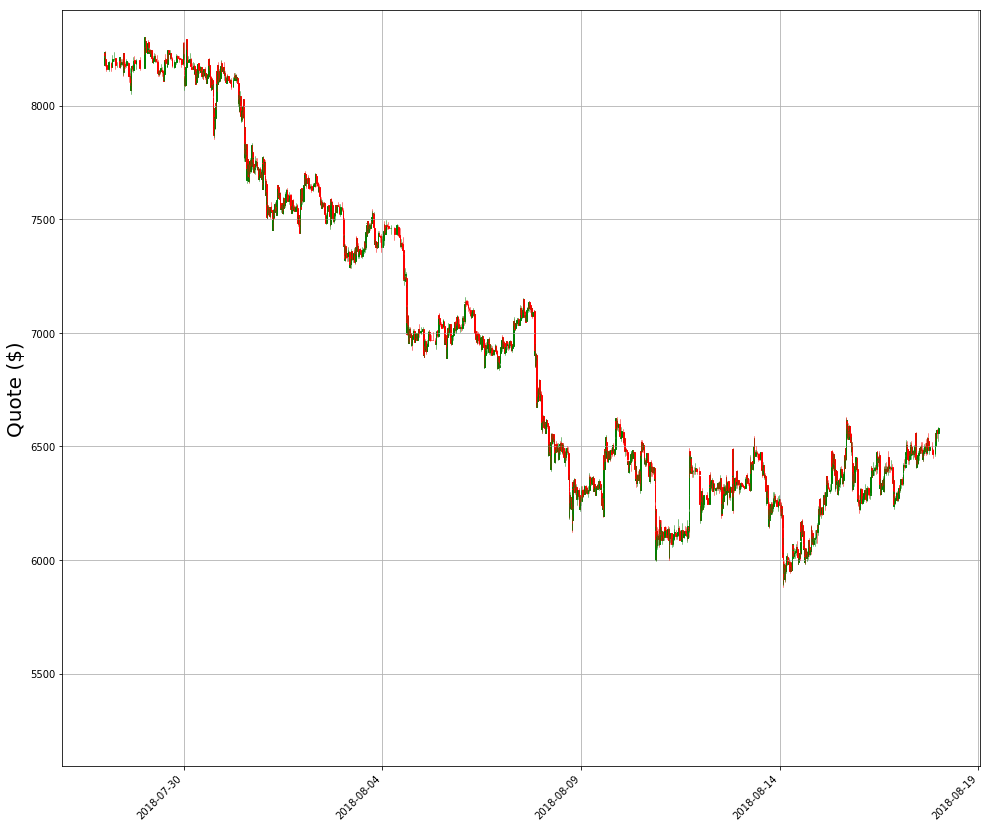

In [8]:
datafile = path+"/dollar_bars.csv"
r = mlab.csv2rec(datafile, delimiter=',')
PlotCandlesticks(r)
#print(r)

In [9]:
dollar_bars = create_bar(data, 'transaction', 500000)

#dollar_bars=dollar_bars.assign(dollar_returns=dollar_bars['close'].diff())
#add a column for the returns
dollar_returns_log=np.log(dollar_bars['close']).diff()
dollar_bars=dollar_bars.assign(dollar_returns_log=dollar_returns_log.values)
dollar_bars.head()

,open,high,low,close,volume,transaction,vwap,dollar_returns_log
time_stamp,,,,,,,,
2018-07-28 00:03:28,8177.72,8213.50,8177.72,8213.50,40.711876,334023.790328,8204.578676,NaN
2018-07-28 00:04:18,8216.74,8234.04,8209.89,8234.04,75.915168,624111.674154,8221.172292,0.002498
2018-07-28 00:04:49,8232.14,8238.87,8204.96,8221.93,65.823182,541553.725604,8227.401135,-0.001472
2018-07-28 00:25:48,8205.03,8217.18,8174.81,8180.20,61.068439,500125.822028,8189.595613,-0.005088
2018-07-28 01:08:04,8180.20,8183.49,8152.11,8161.53,58.297761,476165.522835,8167.818390,-0.002285


In [10]:
#add a column for the 20 period std deviation of the log of returns at each bar (volatility)
dollar_bars=dollar_bars.assign(periodVol=dollar_returns_log.ewm(span=20).std())
dollar_bars.head()

,open,high,low,close,volume,transaction,vwap,dollar_returns_log,periodVol
time_stamp,,,,,,,,,
2018-07-28 00:03:28,8177.72,8213.50,8177.72,8213.50,40.711876,334023.790328,8204.578676,NaN,NaN
2018-07-28 00:04:18,8216.74,8234.04,8209.89,8234.04,75.915168,624111.674154,8221.172292,0.002498,NaN
2018-07-28 00:04:49,8232.14,8238.87,8204.96,8221.93,65.823182,541553.725604,8227.401135,-0.001472,0.002807
2018-07-28 00:25:48,8205.03,8217.18,8174.81,8180.20,61.068439,500125.822028,8189.595613,-0.005088,0.003785
2018-07-28 01:08:04,8180.20,8183.49,8152.11,8161.53,58.297761,476165.522835,8167.818390,-0.002285,0.003032


#### Defining Target 
<font color='black'>
> **We define the target as 1 if price moves up more than periodVol value, and 0 otherwise

In [11]:
dollar_bars=dollar_bars.assign(Target=np.nan)
dollar_bars['Target']= 0
dollar_bars['Target'][dollar_bars.dollar_returns_log>dollar_bars.periodVol] =1

#### Feature engineering and Determing input variable 
<font color='black'>
> * Adding technical indicators
* Statndard Scaling    

In [12]:
#Exponential Moving Average  
def EMA(df, n):  
    
    EMA = pd.Series(df['close'].ewm(span=n).mean(), name = 'ema_' + str(n))  
    df = df.join(EMA)  
    return df

#Momentum  
def MOM(df, n):  
    M = pd.Series(df['close'].diff(n), name = 'momentum_' + str(n))  
    df = df.join(M)  
    return df

#Relative Strength Index  
def RSI(df, n):  
    i = 0  
    UpI = [0]  
    DoI = [0]  
    while i  < df['close'].count()-1:
        UpMove = df['high'].iat[i + 1] - df['high'].iat[i]
        DoMove = df['low'].iat[i] - df['low'].iat[i + 1]  
        if UpMove > DoMove and UpMove > 0:  
            UpD = UpMove  
        else: UpD = 0  
        UpI.append(UpD)  
        if DoMove > UpMove and DoMove > 0:  
            DoD = DoMove  
        else: DoD = 0  
        DoI.append(DoD)  
        i = i + 1  
    UpI = pd.Series(UpI)  
    DoI = pd.Series(DoI) 
    
    PosDI = pd.Series(UpI.ewm(span=n,min_periods = n - 1).mean())  
    NegDI = pd.Series(DoI.ewm(span=n,min_periods = n - 1).mean())  
    RSI = pd.Series(PosDI / (PosDI + NegDI), name = 'rsi_' + str(n))  *100
    df = df.assign(RSI=RSI.values)  
    
    return df


#Commodity Channel Index  
def CCI(df, n):  
    
    PP = (df['high'] + df['low'] + df['close']) / 3  
    
    r = PP.rolling(window=n)
    CCI = pd.Series((PP - r.mean()) / r.std(), name = 'CCI_' + str(n))  
    df = df.join(CCI)  
    return df

In [13]:
data = RSI(dollar_bars, 14)
data = MOM(data, 14)
data = CCI(data, 14)
data = EMA(data, 14)
data=data.dropna().drop_duplicates()

In [14]:
input_columns_names = ['open', 'high', 'low', 'close', 'volume', 'transaction', 'vwap','RSI', 'momentum_14','CCI_14', 'ema_14']

> #### Imputing nan and nulls


In [15]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table  

In [16]:
table = impute_nan_with_median(data)

> #### Creating input and Target data sets
<font color='black'>
> * split data set into Target and Input data set

In [17]:
X = table[input_columns_names]
y = table['Target']

#### Cross-Validation
<font color='black'>
> * Fix cross-validation parameters: Kfold - stratified, 7 partitions with shuffle,  random_state.

In [18]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=20)

### Fitting Models
<font color='black'>
> * Will try different modelling methods and find best suited model for our goal
* Models used to fit
    1. Decision Tree
    2. Random Forest
    3. Logistic Regression
    4. Support Vector Machine
* Notes
    * Due to the `imbalance of the classes in the target`, we add the balancing parameter. 
    * We also use the parameter `random_state = 20` for the reproducibility of the results.
    * The main performance metrics of a model is the area under the ROC curve. The closer the value of ROC-AUC to 1, the better the classification is done.
    * other performance metrics:
        * Confusion Metrix
        * Precision, 
        * Recall, 
        * F1-Score
        * Accuracy
        * AUC

> ##### 1. Decision tree and hyperparameter tuning 

In [19]:
dt = DecisionTreeClassifier(random_state=20, class_weight='balanced')

In [20]:
# Find the values of hyperparameters using the `GridSearchCV` which maximize the area under the ROC curve.
# creating parameters for gridsearch

max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7,8,9,10,11]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

dt_grid_search = GridSearchCV(dt, tree_params, n_jobs=-1, scoring ='roc_auc', cv=skf)
dt_grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=20, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=20,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5, 6, 7, 8, 9], 'max_features': [4, 5, 6, 7, 8, 9, 10, 11]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [21]:
print(dt_grid_search.best_score_)
print(dt_grid_search.best_params_)

0.7273829680816498
{'max_depth': 7, 'max_features': 10}


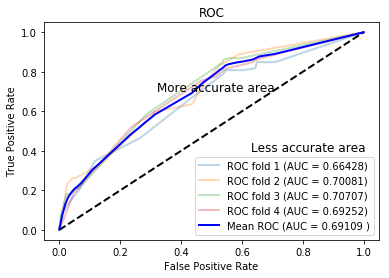

In [22]:
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1

for train,test in skf.split(X,y):
    prediction = dt_grid_search.fit(X.iloc[train].reset_index(drop=True), y.iloc[train].reset_index(drop=True)).predict_proba(X.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.5f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.5f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

Confusion Matrix

[[1361 1323]
 [  35  360]]


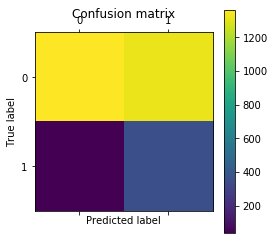

In [26]:
print ("Confusion Matrix\n")
cm = confusion_matrix(y, dt_grid_search.predict(X))

print (cm)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [27]:
print ("precision, recall, fscore \n")
print(precision_recall_fscore_support(y, dt_grid_search.predict(X), average='macro'))

print(precision_recall_fscore_support(y, dt_grid_search.predict(X), average='micro'))

print(precision_recall_fscore_support(y, dt_grid_search.predict(X), average='weighted'))


precision, recall, fscore 

(0.5944160550388429, 0.7092356958252373, 0.5068219347411727, None)
(0.5589477102955505, 0.5589477102955505, 0.5589477102955505, None)
(0.8772977314060768, 0.5589477102955505, 0.6260186382816031, None)


In [30]:
print("AUC\n")
cv_aucs = cross_val_score(DecisionTreeClassifier(random_state=20, max_depth= 7, max_features= 10,class_weight='balanced'), 
                          X.values, y.values, scoring="roc_auc", cv=skf)
print("Mean ROC AUC:", np.mean(cv_aucs))

AUC

Mean ROC AUC: 0.7273844777038305


In [54]:
print("Accuracy\n")
print(accuracy_score(y, dt_grid_search.predict(X)))

Accuracy

0.5589477102955505


> ##### 2. Random Forest and hyperparameter tuning 


In [31]:
max_depth_values = range(5, 15)
max_features_values = [4, 5, 6, 7]
forest_params = {'max_depth': max_depth_values,
                'max_features': max_features_values}

In [32]:
rf = RandomForestClassifier(random_state=20, n_jobs=-1, 
                            class_weight='balanced')
rf_grid_search = GridSearchCV(rf, forest_params, n_jobs=-1, 
                              scoring='roc_auc', cv=skf)
rf_grid_search.fit(X.values, y.values)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=20, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=20,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(5, 15), 'max_features': [4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [33]:
print(rf_grid_search.best_score_)

0.765058858389025


In [34]:
print(rf_grid_search.best_params_)

{'max_depth': 14, 'max_features': 5}


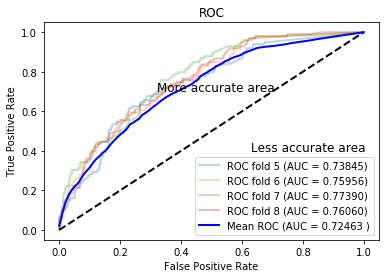

In [35]:
for train,test in skf.split(X,y):
    prediction = rf_grid_search.fit(X.iloc[train].reset_index(drop=True), y.iloc[train].reset_index(drop=True)).predict_proba(X.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.5f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.5f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

Confusion Matrix

[[1890  794]
 [  68  327]]


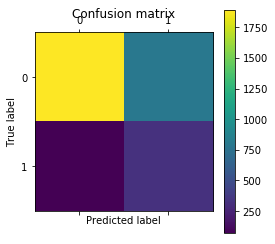

In [36]:
print ("Confusion Matrix\n")
cm = confusion_matrix(y, rf_grid_search.predict(X))

print (cm)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [37]:
print ("precision, recall, fscore \n")
print(precision_recall_fscore_support(y, rf_grid_search.predict(X), average='macro'))

print(precision_recall_fscore_support(y, rf_grid_search.predict(X), average='micro'))

print(precision_recall_fscore_support(y, rf_grid_search.predict(X), average='weighted'))


precision, recall, fscore 

(0.6284872601163233, 0.7660104887849233, 0.6228512980598163, None)
(0.7200389736927574, 0.7200389736927574, 0.7200389736927574, None)
(0.8788598674956036, 0.7200389736927574, 0.7651818095913595, None)


In [38]:
print("AUC\n")
cv_aucs = cross_val_score(RandomForestClassifier(max_depth= 13, max_features= 6,class_weight='balanced',random_state=20), 
                          X.values, y.values, scoring="roc_auc", cv=skf)
print("Mean ROC AUC:", np.mean(cv_aucs))

AUC

Mean ROC AUC: 0.7519683052736065


In [55]:
print("Accuracy\n")
print(accuracy_score(y, rf_grid_search.predict(X)))

Accuracy

0.7200389736927574


> ##### 3. Logistic Regression and hyperparameter tuning 


In [39]:
scaler = StandardScaler()
logit = LogisticRegression(random_state=20, class_weight='balanced')

logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
logit_pipe_params = {'logit__C': np.logspace(-8, 8, 17)}

In [40]:
logit_pipe_grid_search = GridSearchCV(logit_pipe, logit_pipe_params, n_jobs=-1, 
                           scoring ='roc_auc', cv=skf)
logit_pipe_grid_search.fit(X.values, y.values)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=20, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=20,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'logit__C': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [41]:
print(logit_pipe_grid_search.best_score_)
print(logit_pipe_grid_search.best_params_)

0.9913092329472689
{'logit__C': 1000.0}


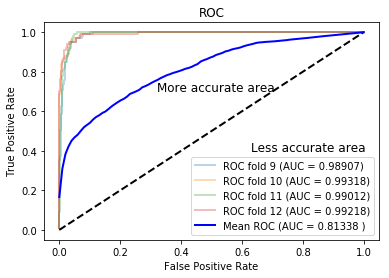

In [42]:
for train,test in skf.split(X,y):
    prediction = logit_pipe_grid_search.fit(X.iloc[train].reset_index(drop=True), y.iloc[train].reset_index(drop=True)).predict_proba(X.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.5f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.5f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

Confusion Matrix

[[2558  126]
 [  11  384]]


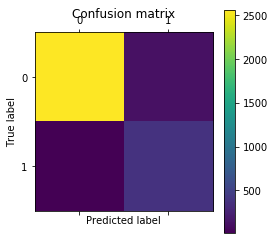

In [43]:
print ("Confusion Matrix\n")
cm = confusion_matrix(y, logit_pipe_grid_search.predict(X))

print (cm)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [44]:
print ("precision, recall, fscore \n")
print(precision_recall_fscore_support(y, logit_pipe_grid_search.predict(X), average='macro'))

print(precision_recall_fscore_support(y, logit_pipe_grid_search.predict(X), average='micro'))

print(precision_recall_fscore_support(y, logit_pipe_grid_search.predict(X), average='weighted'))


precision, recall, fscore 

(0.8743296773750372, 0.9626035201569545, 0.9112692247418733, None)
(0.9555050341019812, 0.9555050341019812, 0.9555050341019812, None)
(0.964572703867497, 0.9555050341019812, 0.9578450148179022, None)


In [45]:
print("AUC\n")
logit = LogisticRegression(random_state=20, class_weight='balanced',C = 1000.0)
logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])

cv_aucs = cross_val_score(logit_pipe, X.values, y.values, scoring="roc_auc", cv=skf)
print("Mean ROC AUC:", np.mean(cv_aucs))


AUC

Mean ROC AUC: 0.9913095414745404


In [56]:

print("Accuracy\n")
print(accuracy_score(y, logit_pipe_grid_search.predict(X)))

Accuracy

0.9555050341019812


> ##### 3. SVM and hyperparameter tuning 

In [46]:
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
svm_grid_search = GridSearchCV(svm.SVC(kernel='rbf',class_weight='balanced'), param_grid, scoring ='roc_auc', cv=skf)
svm_grid_search.fit(X.values, y.values)



GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=20, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [47]:
print(svm_grid_search.best_score_)
print(svm_grid_search.best_params_)

0.624329390089244
{'C': 0.1, 'gamma': 0.001}


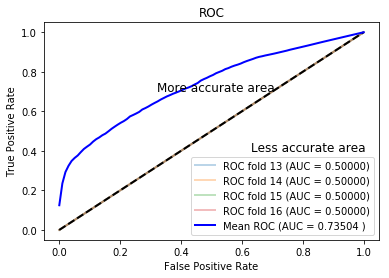

In [48]:
for train,test in skf.split(X,y):
    prediction = svm_grid_search.fit(X.iloc[train].reset_index(drop=True), y.iloc[train].reset_index(drop=True)).predict(X.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction)
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.5f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.5f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

precision, recall, fscore 

Confusion Matrix

[[2684    0]
 [  98  297]]


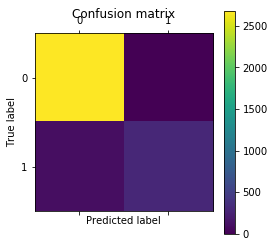

In [49]:
print ("Confusion Matrix\n")
cm = confusion_matrix(y, svm_grid_search.predict(X))

print (cm)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [50]:
print ("precision, recall, fscore \n")

print(precision_recall_fscore_support(y, svm_grid_search.predict(X), average='macro'))

print(precision_recall_fscore_support(y, svm_grid_search.predict(X), average='micro'))

print(precision_recall_fscore_support(y, svm_grid_search.predict(X), average='weighted'))


precision, recall, fscore 

(0.9823867721063984, 0.8759493670886076, 0.9202262435782738, None)
(0.9681714842481325, 0.9681714842481325, 0.9681714842481325, None)
(0.969292690051038, 0.9681714842481325, 0.9662030579449712, None)


In [51]:
print("AUC\n")

cv_aucs = cross_val_score(svm.SVC(kernel='rbf',class_weight='balanced',C= 0.1, gamma= 0.001), X.values, y.values, scoring="roc_auc", cv=skf)
print("Mean ROC AUC:", np.mean(cv_aucs))

AUC

Mean ROC AUC: 0.6243329344111759


In [57]:

print("Accuracy\n")
print(accuracy_score(y, svm_grid_search.predict(X)))

Accuracy

0.9681714842481325


##### wheather PCA will improve the performance
<font color='black'>
> * looking into model performance we feel PCA didn't help so we are avoiding
* There is a lot of overlap in the data using PCA or LDA so we are not going to attempt feature reduction    

In [58]:
from sklearn.decomposition import PCA
# Import different modules for using with the notebook
from IPython.display import display
from IPython.display import Image
from IPython.display import HTML

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
principalDf.head()

,pc1,pc2
0,51448.388051,-3172.643868
1,49084.817618,-3198.333030
2,28483.060503,-3240.782335
3,-16450.292559,-3291.791863
4,91087.468732,-3043.078558


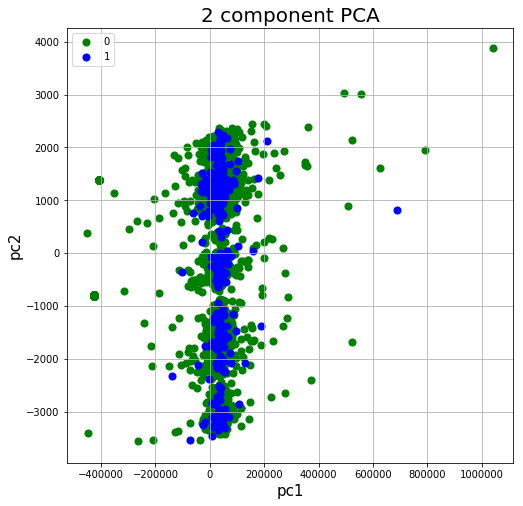

In [59]:
classesDf = pd.DataFrame(data = y.values, columns = ['Target'])

finalDf = pd.concat([principalDf, classesDf], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('pc1', fontsize = 15)
ax.set_ylabel('pc2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ['g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1']
               , finalDf.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


In [60]:
# creating parameters for gridsearch
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [1,2]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

dt_grid_search = GridSearchCV(dt, tree_params, n_jobs=-1, scoring ='roc_auc', cv=skf)
dt_grid_search.fit(principalDf, y)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=20, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=20,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5, 6, 7, 8, 9], 'max_features': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [61]:
print(dt_grid_search.best_score_)
print(dt_grid_search.best_params_)

0.5953268948920918
{'max_depth': 7, 'max_features': 1}


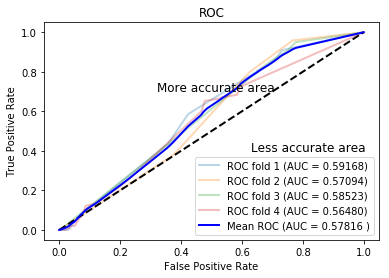

In [62]:
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1

for train,test in skf.split(principalDf, y):
    prediction = dt_grid_search.fit(principalDf.iloc[train].reset_index(drop=True), y.iloc[train].reset_index(drop=True)).predict_proba(principalDf.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.5f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.5f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

In [63]:
scaler = StandardScaler()
logit = LogisticRegression(random_state=20, class_weight='balanced')

logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
logit_pipe_params = {'logit__C': np.logspace(-8, 8, 17)}

In [64]:
logit_pipe_grid_search = GridSearchCV(logit_pipe, logit_pipe_params, n_jobs=-1, 
                           scoring ='roc_auc', cv=skf)
logit_pipe_grid_search.fit(principalDf.values, y.values)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=20, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=20,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'logit__C': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [65]:
print(logit_pipe_grid_search.best_score_)
print(logit_pipe_grid_search.best_params_)

0.5013174145172808
{'logit__C': 10.0}


[[ 612 2072]
 [  63  332]]


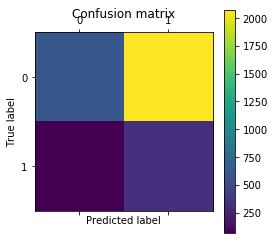

In [66]:
cm = confusion_matrix(y, logit_pipe_grid_search.predict(principalDf.values))

print (cm)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

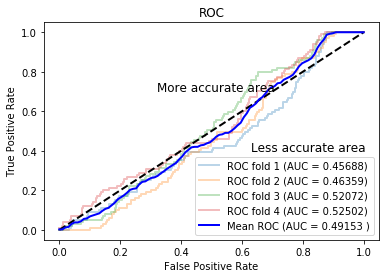

In [67]:
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1

for train,test in skf.split(principalDf, y):
    prediction = logit_pipe_grid_search.fit(principalDf.iloc[train].reset_index(drop=True), y.iloc[train].reset_index(drop=True)).predict_proba(principalDf.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.5f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.5f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

<font color='black'>

======================================================================================================================
### Fund factsheet using PyFolio 

====================================================================================================================== 


In [126]:
stock_rets = (dollar_bars.open - dollar_bars.open .shift(1))/dollar_bars.open.shift(1)
stock_rets =stock_rets.dropna()

Start date,2018-07-28
End date,2018-08-17
Total months,123
,Backtest
Annual return,-2.1%
Cumulative returns,-19.8%
Annual volatility,5.3%
Sharpe ratio,-0.38
Calmar ratio,-0.07
Stability,0.85
Max drawdown,-29.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,29.00,2018-07-29,2018-08-14,NaT,NaN
1,1.98,2018-07-28,2018-07-28,2018-07-29,0
2,0.06,2018-07-29,2018-07-29,2018-07-29,0
3,0.00,2018-07-28,2018-07-28,2018-07-28,0
4,0.00,2018-07-28,2018-07-28,2018-07-28,0


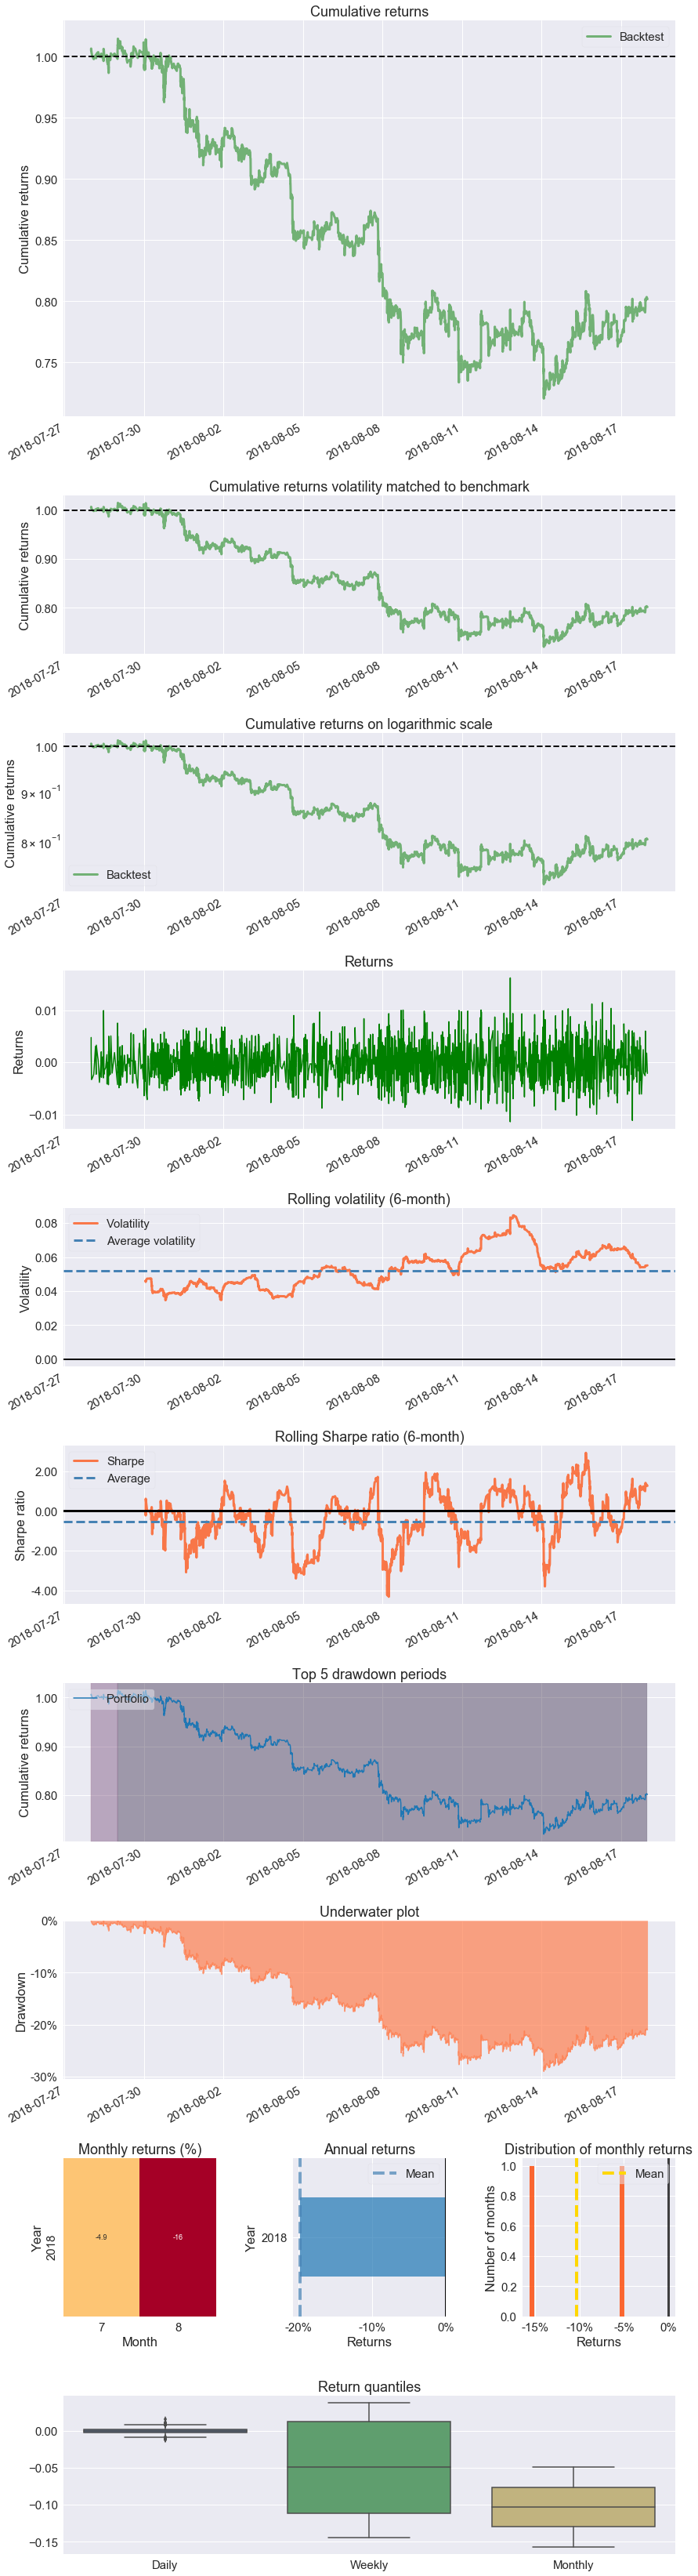

In [128]:
pf.create_returns_tear_sheet(stock_rets )